<a href="https://colab.research.google.com/github/SANAMAREEN/taskrepositery/blob/master/Pre_Trained_Embedding_layer_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [38]:
import os
imdb_dir = '/content/gdrive/My Drive/aclImdb/train'
train_dir = "/content/gdrive/My Drive/aclImdb/train"
labels = []
texts = []
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [40]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [41]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 35487 unique tokens.
Shape of data tensor: (3756, 100)
Shape of label tensor: (3756,)


In [42]:
glove_dir = '/content/gdrive/My Drive/Colab Notebooks'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [43]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [44]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [45]:
model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False

In [46]:
model1.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model1.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 3556 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 2.8499e-04 - acc: 1.0000 - val_loss: 1.7891e-04 - val_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 1.1265e-04 - acc: 1.0000 - val_loss: 1.0474e-04 - val_acc: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 6.1545e-05 - acc: 1.0000 - val_loss: 6.7424e-05 - val_acc: 1.0000
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 3.7070e-05 - acc: 1.0000 - val_loss: 4.4523e-05 - val_acc: 1.0000
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 2.3031e-05 - acc: 1.0000 - val_loss: 3.0394e-05 - val_acc: 1.0000
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 1.4858e-05 - acc: 1.0000 - val_loss: 2.0897e-05 - val_acc: 1.0000
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 9.6813e-06 - acc: 1.0000 - val_loss: 1.

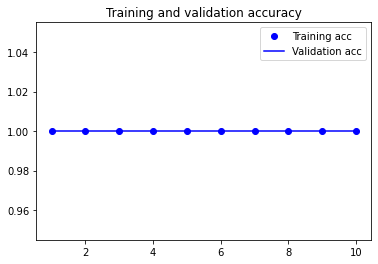

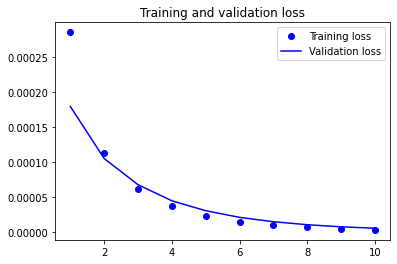

In [47]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
#training without pretrained layer
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 3556 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4398 - acc: 0.8850 - val_loss: 0.0875 - val_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 7.7581e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 8/10
200/200 [=====